# Titanic Kaggle Competition

Some useful tutorials on Kaggle and blogs:
- [Feature undersatdning from plots](https://www.kaggle.com/saisivasriram/titanic-feature-understanding-from-plots)
- [Detailed ensemble learning](https://www.kaggle.com/littleraj30/detailed-ensemble-v-s-other-model-on-titanic)
- [How to score in the top 9%](https://medium.com/i-like-big-data-and-i-cannot-lie/how-i-scored-in-the-top-9-of-kaggles-titanic-machine-learning-challenge-243b5f45c8e9)
- [For learning Logistic Regression](https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python)

Import libraries

In [1]:
# systems
from pathlib import Path
# data handling
import pandas as pd
import numpy as np
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
# machine learning

In [2]:
path = Path('../data/titanic')
list(path.glob('*'))

[PosixPath('../data/titanic/train.csv'),
 PosixPath('../data/titanic/test.csv'),
 PosixPath('../data/titanic/gender_submission.csv'),
 PosixPath('../data/titanic/titanic.zip')]

### 1. Data Exploration

In [3]:
train_path = path.joinpath('train.csv')
train_data = pd.read_csv(train_path)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.shape

(891, 12)

In [5]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

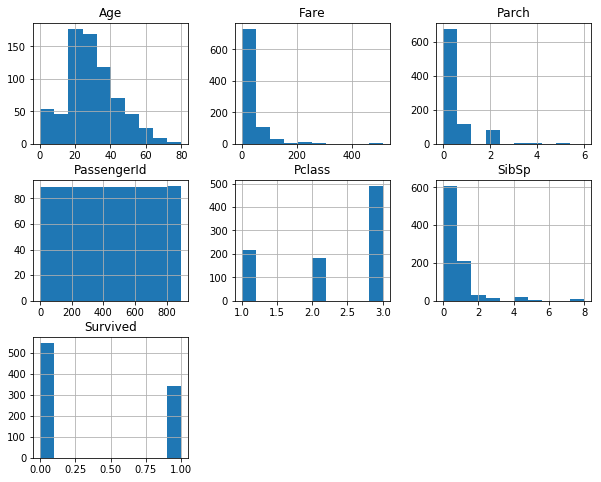

In [6]:
train_data.hist(figsize=(10,8));

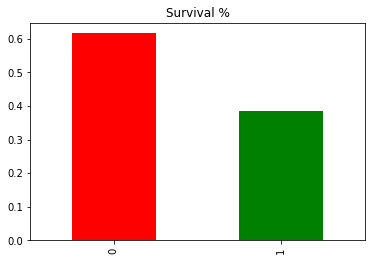

In [7]:
(train_data.Survived
         .value_counts(normalize=True)
         .plot(kind='bar', color=['R', 'G']))
plt.title('Survival %');

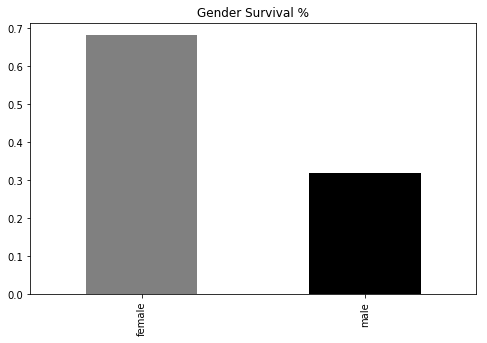

In [8]:
plt.figure(figsize=(8,5))
(train_data.Sex[train_data.Survived == 1]
             .value_counts(normalize=True)
             .plot(kind='bar', color=['Grey', 'Black']))
plt.title('Gender Survival %');

More females survived.

Find the pairwise correlation of all columns in the dataframe. Any non-numeric data type columns in the dataframe are ignored.

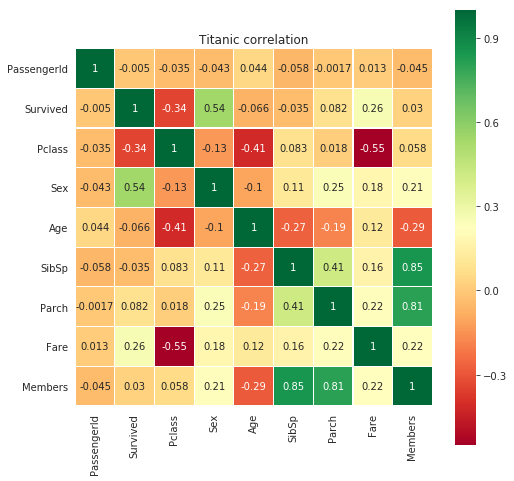

In [40]:
corr = train_data.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, vmax=1, square=True, cmap='RdYlGn', linewidths=0.1, annot=True)
plt.title('Titanic correlation');

In [10]:
train_data.corr()['Survived'].sort_values()

Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
PassengerId   -0.005007
Parch          0.081629
Fare           0.257307
Survived       1.000000
Name: Survived, dtype: float64

Most people survived because of their class, fare, age then parch. 

The box plot visualises survival chance of 1st, 2nd and 3rd class passengers based on age. 

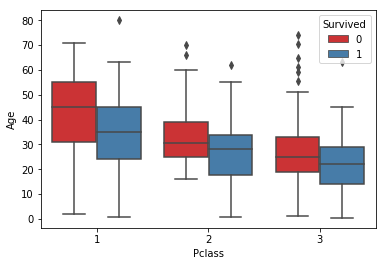

In [11]:
sns.boxplot(x='Pclass', y='Age', hue='Survived', data=train_data, palette='Set1');

Kernel Density Estimation (KDE) visualisation for age within class. Kernel density from [pandas.plot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.kde.html) is a non-parametric smoothing technique which uses Gaussian kernels and includes automatic bandwidth determination. [A useful explanation with interactive javascript plots](https://mglerner.github.io/posts/histograms-and-kernel-density-estimation-kde-2.html?p=28).

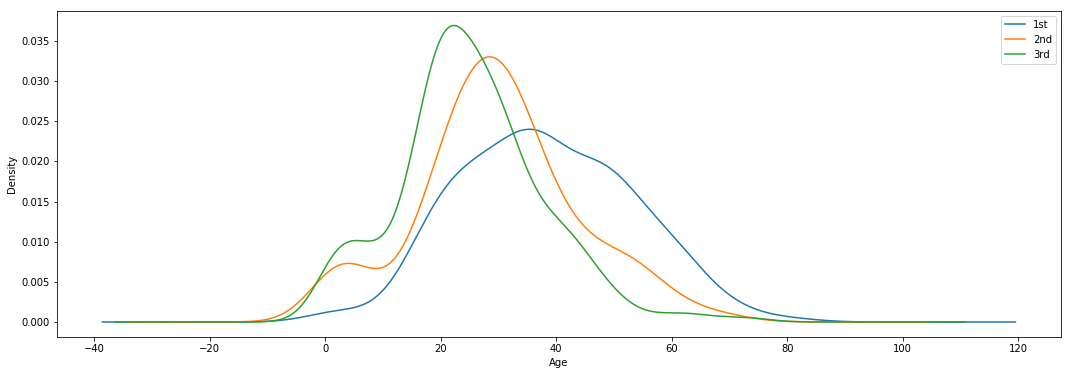

In [12]:
fig = plt.figure(figsize=(18,6))
for x in [1,2,3]:
    train_data.Age[train_data.Pclass == x].plot(kind='kde')
plt.legend(('1st', '2nd', '3rd'))
plt.xlabel('Age')
plt.show()

In [13]:
print(' Youngest: ', min(train_data.Age), '\n', 'Oldest: ', max(train_data.Age))

 Youngest:  0.42 
 Oldest:  80.0


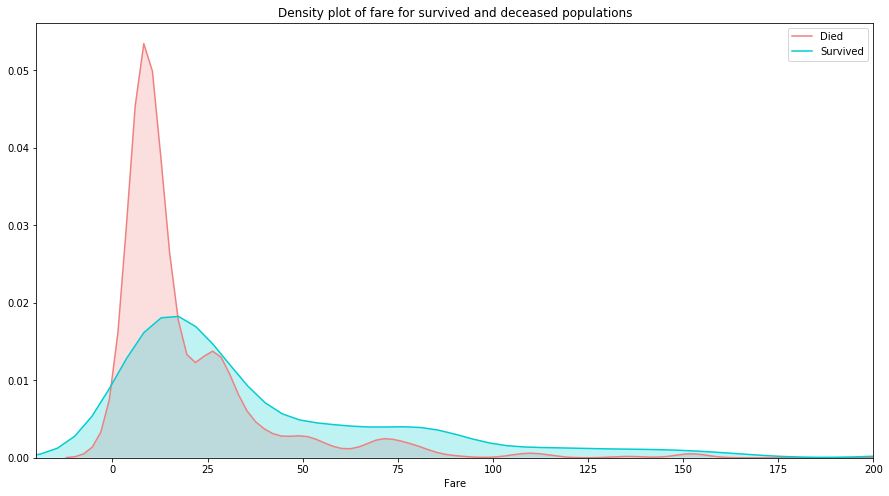

In [14]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(train_data['Fare'][train_data.Survived == 0],
                color='lightcoral', shade=True)
sns.kdeplot(train_data['Fare'][train_data.Survived == 1],
           color='darkturquoise', shade=True)
plt.legend(['Died', 'Survived'])
plt.title('Density plot of fare for survived and deceased populations')
ax.set(xlabel='Fare')
plt.xlim(-20, 200)
plt.show()

In [15]:
for num, i in enumerate(range(1,4)):
    age = train_data.groupby('Pclass').get_group(i).Age.mean()
    print('class', num+1, 'mean age:', age)

class 1 mean age: 38.233440860215055
class 2 mean age: 29.87763005780347
class 3 mean age: 25.14061971830986


Were people with larger families less or more likely to survive?
- SibSp	# of siblings / spouses aboard the Titanic	
- Parch	# of parents / children aboard the Titanic

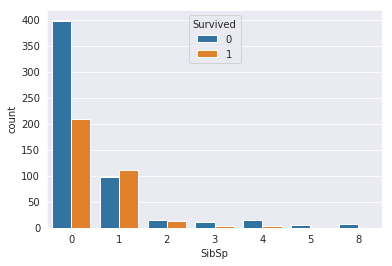

In [16]:
sns.set_style(style='darkgrid')
sns.countplot(x='SibSp', hue='Survived', data=train_data);

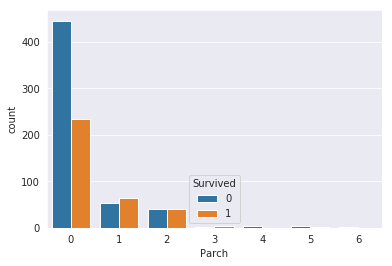

In [17]:
sns.countplot(x='Parch', hue='Survived', data=train_data);

### 2. Create New Features

Create a new feature for the Title of a passengers name, create smaller categories based on title/rank/honorific and then map the Title column. 

In [18]:
def create_title_column_and_standardise(data):
    data['Title'] = (data.Name
                       .apply(lambda name: name.split(',')[1]
                             .split('.')[0].strip()))
    print('Unique titles of original dataset: ', '\n', 
          data.Title.unique())
    simple_titles = {'Mr': 'Mr', 'Mrs': 'Ms', 'Miss': 'Ms', 'Master': 'Master',
    'Don': 'Noble','Rev': 'Rev', 'Dr': 'Dr', 'Mme': 'Ms', 'Mlle': 'Ms',
    'Ms': 'Ms', 'Major': 'Officer', 'Lady': 'Noble', 'Sir': 'Noble',
    'Mlle': 'Ms', 'Col': 'Officer', 'Capt': 'Officer', 'the Countess': 'Noble',
    'Jonkheer': 'Noble'}
    data.Title = data.Title.map(simple_titles)
    print('Standardised Titles: ', '\n', 
          data.Title.value_counts())

In [19]:
create_title_column_and_standardise(train_data)

Unique titles of original dataset:  
 ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']
Standardised Titles:  
 Mr         517
Ms         311
Master      40
Dr           7
Rev          6
Officer      5
Noble        5
Name: Title, dtype: int64


Create a new feature for family groups

In [20]:
def create_family_column(data):
    train_data['Members'] = train_data['Parch'] + train_data['SibSp']
    data.Members.replace([8,9,10,11], 7, inplace=True)

In [21]:
create_family_column(train_data)

In [22]:
train_data.Members.value_counts().sort_values()

6     12
7     13
4     15
5     22
3     29
2    102
1    161
0    537
Name: Members, dtype: int64

### 3. Fill NaN values

In [23]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
Members          0
dtype: int64

Fill age according to Pclass, Sex and Title. [Pandas guidance on missing data](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html).

In [24]:
def fill_missing_age_values(data):
    grouped = data.groupby(['Sex', 'Pclass', 'Title'])
    print(grouped.Age.median())
    data.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))
    
fill_missing_age_values(train_data)

Sex     Pclass  Title  
female  1       Dr         49.0
                Ms         35.0
                Noble      40.5
        2       Ms         28.0
        3       Ms         21.5
male    1       Dr         44.0
                Master      4.0
                Mr         40.0
                Noble      40.0
                Officer    56.0
        2       Dr         38.5
                Master      1.0
                Mr         31.0
                Rev        46.5
        3       Master      4.0
                Mr         26.0
Name: Age, dtype: float64


Fill in the null values in Embarked feature.
C = Cherbourg, Q = Queenstown, S = Southampton

In [25]:
train_data[train_data.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Members
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Ms,0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Ms,0


Both paid $80 and travelled first class.

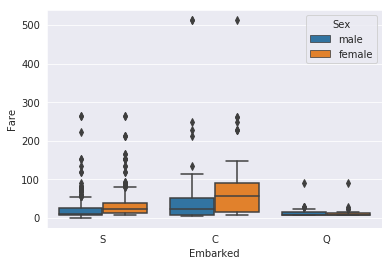

In [26]:
sns.boxplot(x='Embarked', y='Fare', hue='Sex', data=train_data);

Higher paying females travels from Cherbourg. 

In [27]:
train_data['Embarked'] = train_data['Embarked'].fillna('C')

Cabin numbers fill with unknown 'U'

In [28]:
train_data['Cabin'] = train_data['Cabin'].fillna('U')

Remove the numbers and keep the first letter of cabin numbers, there may be a pattern that cabins with a particular letter had greater likelihood of survival. 

In [29]:
train_data['Cabin'] = train_data['Cabin'].map(lambda x: x[0])
train_data['Cabin'].unique()

array(['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [30]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
Title          891 non-null object
Members        891 non-null int64
dtypes: float64(2), int64(6), object(6)
memory usage: 97.5+ KB


### 4. Feature Engineering: categorical data to numerical

The last step to perform before we can begin our modeling is convert all our categorical features to numbers. Random Forest and Logistic Regression algorithms can only take an array of numbers as an input, not names or letters. 

A [great article by Laurae](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931) on finding the best data structure for the machine learning model.

Approaches:
1. Label encoding: simply converting each value in a column to a number. Using `astype` to convert 'object' to 'category' then pandas `.cat.codes` to assign an encoded variable. The problem can be we might confuse our model into thinking that a column has data with some kind of order or hierarchy
2. One hot encoding: implemented in scikit-learn as `sklearn.preprocessing.OneHotEncoder`. Dummy coding/one-hot encoding are also implemented in Pandas as `pandas.get_dummies`. 

In [31]:
train_data['Sex'] = train_data.Sex.map({'male': 0, 'female': 1})

In [32]:
title_encoded = pd.get_dummies(train_data.Title, prefix='Title')
cabin_encoded = pd.get_dummies(train_data.Cabin, prefix='Deck')
embarked_encoded = pd.get_dummies(train_data.Embarked, prefix='Embarked')

In [33]:
titanic_train = pd.concat([train_data, title_encoded, 
                          cabin_encoded, embarked_encoded], axis=1)

In [34]:
titanic_train.drop(['Name', 'Ticket', 'Title',
                   'Cabin', 'Embarked'], axis=1, inplace=True)
titanic_train.shape

(891, 28)

In [35]:
titanic_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Members,Title_Dr,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,0,22.0,1,0,7.2500,1,0,...,0,0,0,0,0,0,1,0,0,1
1,2,1,1,1,38.0,1,0,71.2833,1,0,...,1,0,0,0,0,0,0,1,0,0
2,3,1,3,1,26.0,0,0,7.9250,0,0,...,0,0,0,0,0,0,1,0,0,1
3,4,1,1,1,35.0,1,0,53.1000,1,0,...,1,0,0,0,0,0,0,0,0,1
4,5,0,3,0,35.0,0,0,8.0500,0,0,...,0,0,0,0,0,0,1,0,0,1


In [36]:
X = titanic_train.drop('Survived', axis=1).values
y = titanic_train.Survived.values

In [37]:
X.shape, y.shape

((891, 27), (891,))

In [38]:
type(X)

numpy.ndarray

### 5. Ready for Machine Learning

[Logistic Regression](https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html)

- Logistic regression is a classification algorithm used to assign observations to a discrete set of classes.

- uses the logistic sigmoid function to return a probability value

- 